# OpenAPS Activity Calculations
----
This notebook will replicate and visualize the calculation of insulin `activity` used in the [OpenAPS project](https://github.com/openaps/oref0).

Specifically, it will replicate the javascript code found in [oref0/lib/iob/calculation.js](https://github.com/openaps/oref0/lib/iob/calculation.js) and plot the insulin `activity` curves for a set of Duration of Insulin Activity (`dia`) values.

### First, some definitions:
* **dia** : Duration of Insulin Activity. This is the user specified time (in hours) that insulin lasts in their body after a bolus. This value comes from the user's pump settings. (Not sure whether Medtronic places any limits when setting this value. Testing here assumes integers between 2 and 8 hours.)


* **end** : Duration (in minutes) that insulin is active. end = dia * 60.


* **peak** : Duration (in minutes) when insulin action it's peak activity level.

    **Key Assumption #1**: Given a default value of 3 hours for `dia`, which translates into 180 minutes for `end`, assume that `peak` insulin activity ocurrs between 60 and 90 minutes after dosage. As such, the OpenAPS algorithm assumes that insulin activity peaks at 75 minutes for a `dia` of 3 hours. This assumption is generalizable to other user `dia` settings. That is, `peak` can be expressed as a function of `dia` by multiplying by the ratio (75 / 180):
    
    `peak` = f(`dia`) = (`dia` \* 60 \* (75 / 180))
    
    So, for example, for a `dia` of 4 hours, `peak` will be at 100 minutes:
    
    100 = (4 \* 60 \* (75 / 180))


* **activity** : This is the variable name used in OpenAPS to represent "portion of insulin that was active in the previous minute." 

    **Key Assumption #2**: Activity increases linearly until the `peak` and then decreases linearly (at a slightly slower rate) until the `end`.





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def calc_activity(dia):
    
    peak = 75 # minutes
    end = 180 # minutes
    
    x_list = []
    activity_list = [] 
    
    for i_min in range(0, (dia * 60) + 1):  # Add 1 to get plot at the last minute
        
        i_min = i_min * 3.0 / dia
        
        if (i_min < peak):
            x = (i_min / 5) + 1.0
            x_list.append(x)
            
            activity = (2.0 / dia / 60 / peak) * i_min  # Note: 2.0 needs a decimal representation to cast activity into a float.
            activity_list.append(activity)
            
        elif (i_min < end + 1):             # Add 1 to get plot at the last minute
            x = (i_min - peak) / 5 # Also, why / 5? Is this b/c the coefficients were estimated in 5 min intervals?
            x_list.append(x)
            
            activity = (2.0 / dia / 60 - (i_min - peak) * 2 / dia / 60 / (60 * 3 - peak))
            activity_list.append(activity)
    
    return x_list, activity_list   

In [3]:
# Create a dictionary of DataFrames -- one for each value of DIA between 2 and 8
dict_of_dfs_by_dia = {}

for dia in range(2, 9):                           # Note: range() ends at n-1
    x_list, activity_list = calc_activity(dia)
    activity_df = pd.DataFrame({'x' : x_list, 'activity_dia_' + str(dia) : activity_list})
    
    # Add a cummulative sum column for activity
    activity_df['cum_activity_dia_' + str(dia)] = activity_df['activity_dia_' + str(dia)].cumsum()
   
    # Put df into a dictionary with dia as the key
    dict_of_dfs_by_dia.update({dia : activity_df})

In [4]:
dict_of_dfs_by_dia[3].head()

,activity_dia_3,x,cum_activity_dia_3
0,0.000000,1.0,0.000000
1,0.000148,1.2,0.000148
2,0.000296,1.4,0.000444
3,0.000444,1.6,0.000889
4,0.000593,1.8,0.001481


In [5]:
dict_of_dfs_by_dia[3].tail()

,activity_dia_3,x,cum_activity_dia_3
176,4.232804e-04,20.2,0.999365
177,3.174603e-04,20.4,0.999683
178,2.116402e-04,20.6,0.999894
179,1.058201e-04,20.8,1.000000
180,-1.734723e-18,21.0,1.000000


In [6]:
# Peak activity 
dict_of_dfs_by_dia[3].iloc[74:77, :]

,activity_dia_3,x,cum_activity_dia_3
74,0.010963,15.8,0.411111
75,0.011111,0.0,0.422222
76,0.011005,0.2,0.433228


## Note: 
Area of triangle = 1/2 \* (width \* height)

width = 180 minutes

height = 0.011111

width * height = 1.99998

1/2 * 1.99998 = 0.99999 (close enough to 1!)

## Plot the Activity Curves!

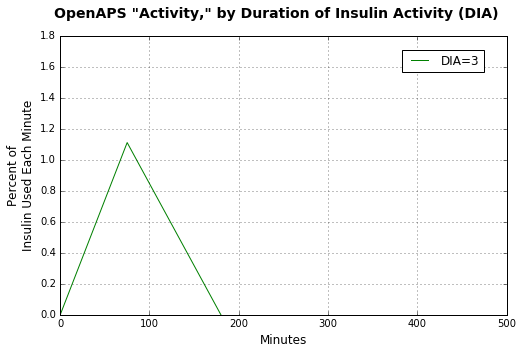

In [7]:
# Plot activity curve for just (dia == 3)
plt.figure(figsize=(8, 5))
plt.ylabel('Percent of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS "Activity," by Duration of Insulin Activity (DIA)', fontsize=14, fontweight='bold')

act_3_pct = dict_of_dfs_by_dia[3]['activity_dia_3'] * 100
act_3_pct.plot(kind='line', label='DIA=3', color='g').grid(True)

plt.xlim([0,500])
plt.ylim([0,1.8])

plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.0)

plt.savefig('OpenAPS_activity_dia_3.png', format='png', dpi=600)

plt.show()

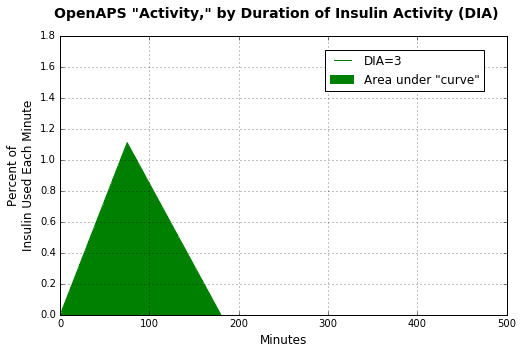

In [15]:
# Plot activity AREA UNDER curve for just (dia == 3)
plt.figure(figsize=(8, 5))
plt.ylabel('Percent of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS "Activity," by Duration of Insulin Activity (DIA)', fontsize=14, fontweight='bold')

act_3_pct = dict_of_dfs_by_dia[3]['activity_dia_3'] * 100 
ax_line = act_3_pct.plot(kind='line', label='DIA=3', color='g').grid(True)
ax_bar = act_3_pct.plot(kind='bar', edgecolor="none", width=1, label='Area under "curve"', color='g').grid(True)

plt.xlim([0,500])
plt.xticks(np.arange(0,501,100), ('0', '100', '200', '300', '400', '500'), rotation='horizontal')
plt.ylim([0,1.8])

plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.0)

plt.savefig('OpenAPS_activity_dia_3_bar.png', format='png', dpi=600)

plt.show()

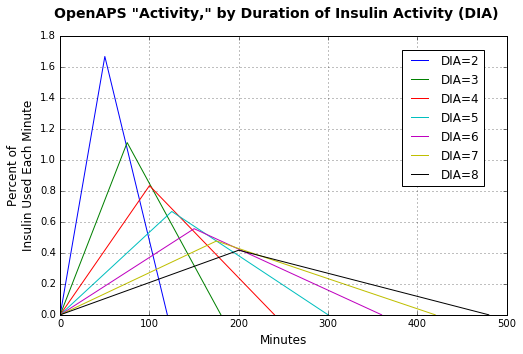

In [9]:
# Plot activity curve for dia = 2 - 8
plt.figure(figsize=(8, 5))
plt.ylabel('Percent of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS "Activity," by Duration of Insulin Activity (DIA)', fontsize=14, fontweight='bold')

for dia in range(2,9):
    dia_str = str(dia)
    (dict_of_dfs_by_dia[dia]['activity_dia_' + dia_str]*100).plot(kind='line', label='DIA='+dia_str).grid(True)

plt.xlim([0,500])
plt.ylim([0,1.8])

plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.)

plt.savefig('OpenAPS_activity_by_dia_2_8.png', format='png', dpi=600)

plt.show()  

## Plot the Cumulative Activity Curves!

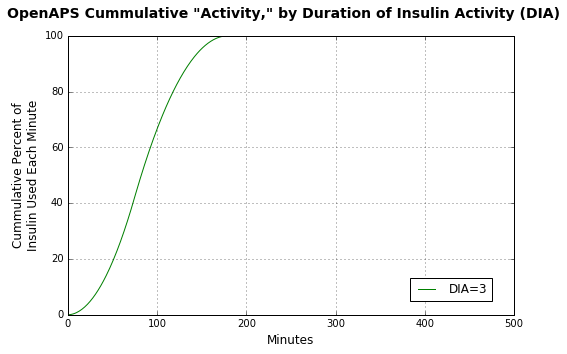

In [10]:
# Plot cummulative activity curve for just (dia == 3)
plt.figure(figsize=(8, 5))
plt.ylabel('Cummulative Percent of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS Cummulative "Activity," by Duration of Insulin Activity (DIA)', fontsize=14, fontweight='bold')

cum_3_pct = dict_of_dfs_by_dia[3]['cum_activity_dia_3'] * 100
cum_3_pct.plot(kind='line', label='DIA=3', color='g').grid(True)

plt.xlim([0,500])
plt.ylim([0,100])
    
plt.legend(bbox_to_anchor=(0.95, 0.05), loc=4, borderaxespad=0.)

plt.savefig('OpenAPS_cum_activity_by_dia_3.png', format='png', dpi=600)

plt.show()  

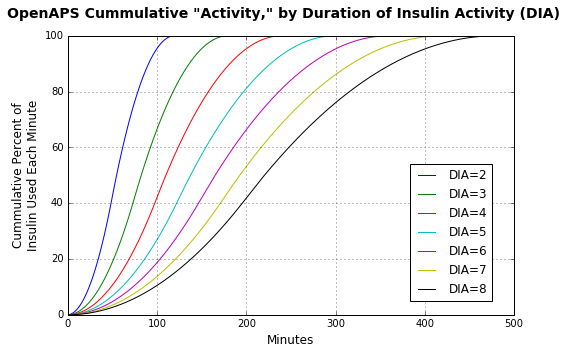

In [11]:
# Plot cumulative activity curves for dia = 2 - 8
plt.figure(figsize=(8, 5))
plt.ylabel('Cummulative Percent of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS Cummulative "Activity," by Duration of Insulin Activity (DIA)', fontsize=14, fontweight='bold')

for dia in range(2,9):
    dia_str = str(dia)
    (dict_of_dfs_by_dia[dia]['cum_activity_dia_' + dia_str]*100).plot(kind='line', label='DIA='+dia_str).grid(True)

plt.xlim([0,500])
plt.ylim([0,100])
    
plt.legend(bbox_to_anchor=(0.95, 0.05), loc=4, borderaxespad=0.)

plt.savefig('OpenAPS_cum_activity_by_dia_2_8.png', format='png', dpi=600)

plt.show()  

# The End...